In [3]:
!pip -q install scikit-learn pandas matplotlib


In [4]:
import pandas as pd
df = pd.read_csv("clean_cv_data.csv")  # yüklediğin dosya adı
print(df.shape)
df.head()


(40001, 3)


,clean_text,main_label,sub_label
0,Jitesh Vishwakarma,meta,others
1,E-mail-Id: - jvishwakarma123@gmail.com,meta,others
2,Contact Number: - 9960902548,meta,others
3,PROFESSIONAL SUMMARY:,header,experience
4,· 4 years of technical experience in implement...,content,experience


In [5]:
# Kaç farklı değer var -> ikili adayları gör
nun = df.nunique(dropna=True).sort_values()
display(nun)

# İlk satırlar
display(df.head(10))

# Veri tipleri
df.dtypes


,0
main_label,3
sub_label,6
clean_text,30676


,clean_text,main_label,sub_label
0,Jitesh Vishwakarma,meta,others
1,E-mail-Id: - jvishwakarma123@gmail.com,meta,others
2,Contact Number: - 9960902548,meta,others
3,PROFESSIONAL SUMMARY:,header,experience
4,· 4 years of technical experience in implement...,content,experience
5,"· Having Domain Experience in PAYMENT, AUTOMOB...",content,experience
6,· Experienced in developing Web based applicat...,content,experience
7,"· Experience in designing, developing and depl...",content,experience
8,· Exposure to AGILE methodologies.,content,experience
9,· Hands on exposure to multiple Application Se...,content,experience


,0
clean_text,object
main_label,object
sub_label,object


In [8]:
import pandas as pd

df = pd.read_csv("clean_cv_data.csv")   # kendi yüklediğin dosya adı
print("Satır ve sütun sayısı:", df.shape)
print("\nSütun isimleri:")
print(list(df.columns))


Satır ve sütun sayısı: (40001, 3)

Sütun isimleri:
['clean_text', 'main_label', 'sub_label']


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. Veriyi oku ---
df = pd.read_csv("clean_cv_data.csv")

# --- 2. Hedef sütunu seç ---
TARGET_COL = "main_label"
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype("category")

print("Hedef sınıf sayısı:", y.nunique())

# --- 3. Metin dışındaki sütunları ayır ---
X = X.drop(columns=["clean_text"], errors="ignore")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# --- 4. Pipeline tanımla ---
pre = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
])

clf = LogisticRegression(max_iter=2000, multi_class="multinomial", solver="lbfgs")

pipe = Pipeline([("prep", pre), ("clf", clf)])

# --- 5. Train/test böl ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. Eğit ve değerlendir ---
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


Hedef sınıf sayısı: 3


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8128
[[5044   55  370]
 [ 621   82  367]
 [  85    0 1377]]
              precision    recall  f1-score   support

     content       0.88      0.92      0.90      5469
      header       0.60      0.08      0.14      1070
        meta       0.65      0.94      0.77      1462

    accuracy                           0.81      8001
   macro avg       0.71      0.65      0.60      8001
weighted avg       0.80      0.81      0.77      8001



In [12]:
# === TF-IDF + Logistic Regression (çok-sınıflı) ===
# Gerekiyorsa: !pip -q install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# ---- 1) Veriyi yükle ----
df = pd.read_csv("clean_cv_data.csv")

TARGET_COL = "main_label"   # hedef etiket
TEXT_COL   = "clean_text"   # metin sütunu

# Metindeki NaN'leri boş string yap (TF-IDF için şart)
if TEXT_COL in df.columns:
    df[TEXT_COL] = df[TEXT_COL].fillna("")
else:
    raise SystemExit(f"'{TEXT_COL}' sütunu yok.")

# ---- 2) X/y oluştur ----
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype("category")

# İsteğe bağlı: metin dışında kalan (sayısal/kategorik) ek özellikler de dahil olsun
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# metin olmayan ve sayısal olmayan kolonlar (kategorik)
cat_cols = [c for c in X.columns if c not in num_cols and c != TEXT_COL]

print("Sınıf sayısı:", y.nunique())
print("Eklenen sayısal özellikler:", num_cols)
print("Eklenen kategorik özellikler:", cat_cols)

# ---- 3) Preprocess + Model pipeline ----
pre = ColumnTransformer([
    # Metin: TF-IDF (unigram+bigram, küçük harf, küçük gürültüyü kırpmak için min_df=2)
    ("txt", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2, max_features=50000), TEXT_COL),
    # Sayısal: ölçekleme
    ("num", StandardScaler(with_mean=False), num_cols),
    # Kategorik: OneHot (yeni sklearn için sparse_output kullan)
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
], remainder="drop")

# Çok-sınıflı lojistik (softmax)
clf = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    multi_class="multinomial",
    C=1.0,
)

pipe = Pipeline([("prep", pre), ("clf", clf)])

# ---- 4) Train/Test böl ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- 5) Eğit & değerlendir ----
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))


Sınıf sayısı: 3
Eklenen sayısal özellikler: []
Eklenen kategorik özellikler: ['sub_label']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9188
[[5197   92  180]
 [ 164  815   91]
 [  81   42 1339]]
              precision    recall  f1-score   support

     content      0.955     0.950     0.953      5469
      header      0.859     0.762     0.807      1070
        meta      0.832     0.916     0.872      1462

    accuracy                          0.919      8001
   macro avg      0.882     0.876     0.877      8001
weighted avg      0.920     0.919     0.918      8001



In [13]:
# === TF-IDF + Logistic Regression (sadece clean_text + opsiyonel sayısal) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, inspect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("clean_cv_data.csv")
TARGET_COL = "main_label"
TEXT_COL   = "clean_text"

df[TEXT_COL] = df[TEXT_COL].fillna("")
X = df.drop(columns=[TARGET_COL])

# >>> sub_label'ı kesin olarak düş <<<  (soruna neden olan kolon)
X = X.drop(columns=["sub_label"], errors="ignore")

y = df[TARGET_COL].astype("category")

# sadece sayısal ek alanlar (varsa) dahil olsun; kategorik kullanmıyoruz
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = []  # kategorikleri kapattık ki tahminde zorunluluk olmasın

def make_ohe():
    import inspect
    if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    return OneHotEncoder(handle_unknown="ignore")

pre = ColumnTransformer([
    ("txt", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2, max_features=50000), TEXT_COL),
    ("num", StandardScaler(with_mean=False), num_cols),
    # kategorik adımı kaldırdık
], remainder="drop")

clf = LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="multinomial", C=1.0)
pipe = Pipeline([("prep", pre), ("clf", clf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

# ---- Örnek tahmin (artık sadece TEXT_COL yeterli) ----
sample_texts = ["örnek bir cümle", "ikinci örnek metin"]
samples_df = pd.DataFrame({TEXT_COL: sample_texts})
pred_labels = pipe.predict(samples_df)
pred_proba  = pipe.predict_proba(samples_df)
classes = pipe.named_steps["clf"].classes_

for t, yhat, p in zip(sample_texts, pred_labels, pred_proba):
    print(f"\nMetin: {t}\n -> Tahmin: {yhat} | Olasılıklar: {dict(zip(classes, np.round(p,3)))}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8788
[[5249  111  109]
 [ 184  815   71]
 [ 449   46  967]]
              precision    recall  f1-score   support

     content      0.892     0.960     0.925      5469
      header      0.838     0.762     0.798      1070
        meta      0.843     0.661     0.741      1462

    accuracy                          0.879      8001
   macro avg      0.858     0.794     0.821      8001
weighted avg      0.876     0.879     0.874      8001


Metin: örnek bir cümle
 -> Tahmin: content | Olasılıklar: {'content': np.float64(0.613), 'header': np.float64(0.069), 'meta': np.float64(0.318)}

Metin: ikinci örnek metin
 -> Tahmin: content | Olasılıklar: {'content': np.float64(0.613), 'header': np.float64(0.069), 'meta': np.float64(0.318)}


In [14]:
# Paketler (gerekirse)
# !pip -q install scikit-learn pandas matplotlib shap joblib

import numpy as np, pandas as pd, inspect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---- veriyi yükle ----
df = pd.read_csv("clean_cv_data.csv")
TARGET_COL = "main_label"
TEXT_COL   = "clean_text"

# metin NaN -> ""
df[TEXT_COL] = df[TEXT_COL].fillna("")

# girdi/çıktı
X = df.drop(columns=[TARGET_COL]).drop(columns=["sub_label"], errors="ignore")  # sub_label'ı çıkar
y = df[TARGET_COL].astype("category")

# opsiyonel sayısal kolonlar (varsa eklenir)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# OHE gerekmiyor; kategorik kullanmıyoruz ki tahminde zorunluluk yaratmasın
pre = ColumnTransformer([
    ("txt", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2, max_features=50000), TEXT_COL),
    ("num", StandardScaler(with_mean=False), num_cols),
], remainder="drop")

clf = LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="multinomial", C=1.0)
pipe = Pipeline([("prep", pre), ("clf", clf)])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe.fit(X_tr, y_tr)
pred = pipe.predict(X_te)

print("Baseline Accuracy:", round(accuracy_score(y_te, pred), 4))
print(confusion_matrix(y_te, pred))
print(classification_report(y_te, pred, digits=3))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline Accuracy: 0.8788
[[5249  111  109]
 [ 184  815   71]
 [ 449   46  967]]
              precision    recall  f1-score   support

     content      0.892     0.960     0.925      5469
      header      0.838     0.762     0.798      1070
        meta      0.843     0.661     0.741      1462

    accuracy                          0.879      8001
   macro avg      0.858     0.794     0.821      8001
weighted avg      0.876     0.879     0.874      8001



In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "prep__txt__ngram_range": [(1,1), (1,2), (1,3)],
    "prep__txt__min_df": [1, 2, 3],
    "prep__txt__max_features": [30000, 50000, 80000],
    "clf__C": [0.1, 0.5, 1.0, 2.0],
    # multinomial için güvenli olan penalty/solver: l2 + lbfgs/saga
    "clf__solver": ["lbfgs", "saga"],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",   # istersen "f1_macro"
    n_jobs=-1,
    verbose=1
)

grid.fit(X_tr, y_tr)
print("En iyi params:", grid.best_params_)
print("CV En iyi skor:", round(grid.best_score_, 4))

best_pipe = grid.best_estimator_
pred = best_pipe.predict(X_te)
print("Test Accuracy (best):", round(accuracy_score(y_te, pred), 4))
print(classification_report(y_te, pred, digits=3))


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


En iyi params: {'clf__C': 2.0, 'clf__solver': 'lbfgs', 'prep__txt__max_features': 80000, 'prep__txt__min_df': 1, 'prep__txt__ngram_range': (1, 2)}
CV En iyi skor: 0.8723
Test Accuracy (best): 0.8821
              precision    recall  f1-score   support

     content      0.897     0.959     0.927      5469
      header      0.830     0.781     0.805      1070
        meta      0.851     0.670     0.749      1462

    accuracy                          0.882      8001
   macro avg      0.859     0.803     0.827      8001
weighted avg      0.880     0.882     0.878      8001



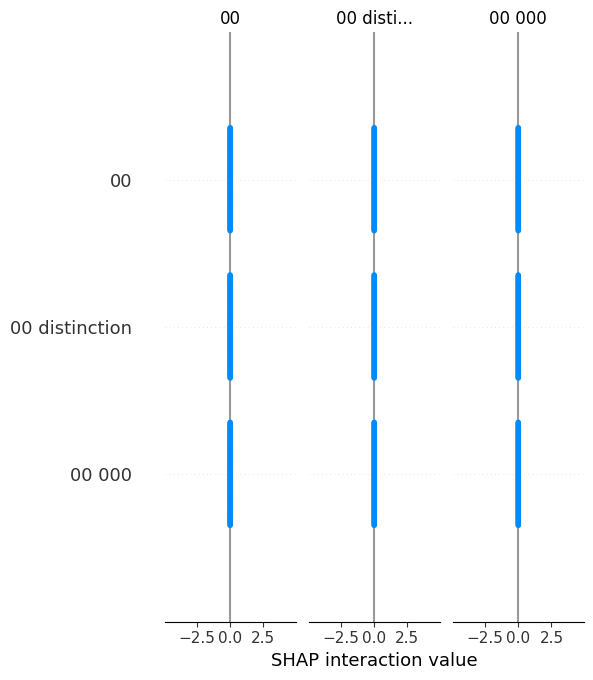

In [18]:
# === SHAP (LinearExplainer) — DÜZELTİLDİ ===
import numpy as np, scipy.sparse as sp
import shap
import matplotlib.pyplot as plt

# best_pipe, X_tr, X_te, num_cols önceki adımlardan geliyor

# 1) Dönüşümler
X_tr_t = best_pipe.named_steps["prep"].transform(X_tr)
X_te_t = best_pipe.named_steps["prep"].transform(X_te)

# 2) Örneklem (hız/bellek için)
rng = np.random.RandomState(42)
bg_idx = rng.choice(X_tr_t.shape[0], size=min(100, X_tr_t.shape[0]), replace=False)
te_idx = rng.choice(X_te_t.shape[0], size=min(100, X_te_t.shape[0]), replace=False)
X_bg = X_tr_t[bg_idx]
X_explain = X_te_t[te_idx]

# 3) Masker + Explainer  ✅ kritik düzeltme
masker = shap.maskers.Independent(X_bg)  # sparse destekli
explainer = shap.LinearExplainer(
    model=best_pipe.named_steps["clf"],
    masker=masker,
    feature_perturbation="interventional"   # <— geçerli seçenek
)

# 4) SHAP değerleri
shap_vals = explainer.shap_values(X_explain)

# 5) Özellik adları (TF-IDF + sayısal)
tfv = best_pipe.named_steps["prep"].named_transformers_["txt"]
feature_names = tfv.get_feature_names_out().tolist() + list(num_cols)

# 6) Görselleştirme
from sklearn.linear_model import LogisticRegression
clf = best_pipe.named_steps["clf"]
classes = clf.classes_

X_explain_dense = X_explain.toarray() if sp.issparse(X_explain) else X_explain

if isinstance(shap_vals, list):  # çok-sınıflı
    for i, c in enumerate(classes):
        print(f"\nSınıf: {c} — en etkili özellikler")
        shap.summary_plot(shap_vals[i], X_explain_dense, feature_names=feature_names, show=True)
else:  # ikili
    shap.summary_plot(shap_vals, X_explain_dense, feature_names=feature_names, show=True)


In [19]:
from sklearn.metrics import f1_score

tries = [
    {"ngram_range": (1,1), "min_df": 1, "max_features": 30000},
    {"ngram_range": (1,2), "min_df": 2, "max_features": 50000},
    {"ngram_range": (1,3), "min_df": 3, "max_features": 80000},
]

for i, cfg in enumerate(tries, 1):
    pre_try = ColumnTransformer([
        ("txt", TfidfVectorizer(**cfg), TEXT_COL),
        ("num", StandardScaler(with_mean=False), num_cols),
    ])
    pipe_try = Pipeline([("prep", pre_try),
                         ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="multinomial"))])
    pipe_try.fit(X_tr, y_tr)
    p = pipe_try.predict(X_te)
    acc = accuracy_score(y_te, p)
    f1m = f1_score(y_te, p, average="macro")
    print(f"Try {i} {cfg} -> acc={acc:.4f} | f1_macro={f1m:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Try 1 {'ngram_range': (1, 1), 'min_df': 1, 'max_features': 30000} -> acc=0.8790 | f1_macro=0.8228


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Try 2 {'ngram_range': (1, 2), 'min_df': 2, 'max_features': 50000} -> acc=0.8788 | f1_macro=0.8215


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Try 3 {'ngram_range': (1, 3), 'min_df': 3, 'max_features': 80000} -> acc=0.8775 | f1_macro=0.8196


In [20]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Tek bir TF-IDF ayarı seçelim (grid'den gelen en iyiyi istersen kullan)
pre_base = best_pipe.named_steps["prep"]

models = {
    "Logistic": LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="multinomial"),
    "LinearSVC": LinearSVC(),                 # hızlı ve güçlü
    "ComplementNB": ComplementNB(),           # metinde çoğu zaman iyi
    "RandomForest": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
}

for name, clf_m in models.items():
    pipe_m = Pipeline([("prep", pre_base), ("clf", clf_m)])
    pipe_m.fit(X_tr, y_tr)
    p = pipe_m.predict(X_te)
    acc = accuracy_score(y_te, p)
    f1m = f1_score(y_te, p, average="macro")
    print(f"{name:12s} -> acc={acc:.4f} | f1_macro={f1m:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic     -> acc=0.8803 | f1_macro=0.8232
LinearSVC    -> acc=0.8813 | f1_macro=0.8259
ComplementNB -> acc=0.8791 | f1_macro=0.8282
RandomForest -> acc=0.8768 | f1_macro=0.8304


In [21]:
import joblib

final_model = best_pipe   # istersen en iyi bulduğumuz pipeline
joblib.dump(final_model, "logreg_tfidf_model.pkl")
print("Kaydedildi: logreg_tfidf_model.pkl")

# Yükleme ve tahmin
loaded = joblib.load("logreg_tfidf_model.pkl")
sample_texts = ["örnek bir cümle", "ikinci örnek metin"]
samples_df = pd.DataFrame({TEXT_COL: sample_texts})
print(loaded.predict(samples_df))
print(loaded.predict_proba(samples_df))  # LinearSVC için çalışmaz, Logistic/NaiveBayes için çalışır


Kaydedildi: logreg_tfidf_model.pkl
['content' 'content']
[[0.591365   0.05776759 0.35086741]
 [0.591365   0.05776759 0.35086741]]


In [22]:
# 1) EĞİTİM
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

CSV_PATH   = "clean_cv_data.csv"
TEXT_COL   = "clean_text"
TARGET_COL = "main_label"

df = pd.read_csv(CSV_PATH)
df[TEXT_COL] = df[TEXT_COL].fillna("")
X = df[TEXT_COL]
y = df[TARGET_COL].astype("category")

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50000, lowercase=True, strip_accents="unicode")),
    ("clf", LogisticRegression(max_iter=3000, multi_class="multinomial", solver="lbfgs"))
])

pipe.fit(X_tr, y_tr)
pred = pipe.predict(X_te)

print("Accuracy:", round(accuracy_score(y_te, pred), 4))
print(classification_report(y_te, pred, digits=3))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8786
              precision    recall  f1-score   support

     content      0.892     0.960     0.925      5469
      header      0.838     0.761     0.798      1070
        meta      0.844     0.661     0.741      1462

    accuracy                          0.879      8001
   macro avg      0.858     0.794     0.821      8001
weighted avg      0.876     0.879     0.874      8001



In [23]:
# 2) KAYDET
import joblib
joblib.dump(pipe, "logreg_tfidf.pkl")
print("Model kaydedildi: logreg_tfidf.pkl")


Model kaydedildi: logreg_tfidf.pkl


In [24]:
# 3) TAHMİN (örnek cümleler)
import pandas as pd, numpy as np, joblib
model = joblib.load("logreg_tfidf.pkl")

samples = ["bu deneyim harikaydı", "çok kötüydü tavsiye etmem"]
pred = model.predict(pd.Series(samples, name=TEXT_COL))
proba = model.predict_proba(pd.Series(samples, name=TEXT_COL))
labels = model.classes_.tolist()

for s, yhat, p in zip(samples, pred, proba):
    print(f"\nMetin: {s}\nTahmin: {yhat}\nOlasılıklar: {dict(zip(labels, np.round(p,3)))}")



Metin: bu deneyim harikaydı
Tahmin: content
Olasılıklar: {'content': np.float64(0.618), 'header': np.float64(0.068), 'meta': np.float64(0.314)}

Metin: çok kötüydü tavsiye etmem
Tahmin: content
Olasılıklar: {'content': np.float64(0.613), 'header': np.float64(0.069), 'meta': np.float64(0.318)}
